In [64]:
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
import matplotlib
import seaborn as sns
sns.set()
sns.set_context("talk", font_scale = 1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['legend.title_fontsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
# matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.figsize'] = [8, 6]

DATA_DIR = r"D:\\data\\lc_data\\data\\"

PLOT_DIR = r"D:\\plots\\lc_pollutant\\plots\\"

In [42]:
def load_data(files, classification):
    best_file = ''
    best_ytrue = []
    best_ypred = []
    if classification == 0:
        best_metric = 100000
    else:
        best_metric = -100000
    for file in files:
        cv_files = sorted(glob.glob(file.split("v0")[0] + "v*.pickle"))
        cv_ytrue = []
        cv_ypred = []
        for cv_file in cv_files:
            with open(cv_file, 'rb') as handle:
                y_true = pickle.load(handle, errors='ignore')
                y_pred = pickle.load(handle, errors='ignore')
            if classification == 1:
                y_true = np.argmax(y_true, axis=1)
                y_pred = np.argmax(y_pred, axis=1)
            cv_ytrue.append(y_true)
            cv_ypred.append(y_pred)
        y_true = np.array(cv_ytrue).ravel()
        y_pred = np.array(cv_ypred).ravel()
        if classification == 0:
            metric = mean_squared_error(y_true, y_pred) ** 0.5
            if metric <= best_metric:
                best_metric = metric
                best_file = file
                best_ytrue = cv_ytrue
                best_ypred = cv_ypred
        else:
            metric = f1_score(y_true, y_pred, average='micro')
            if metric >= best_metric:
                best_metric = metric
                best_file = file
                best_ytrue = cv_ytrue
                best_ypred = cv_ypred
    best_file = best_file.split("\\")[-1].split("v0.pickle")[0]
    return best_metric, best_file, best_ytrue, best_ypred

In [43]:
def load_results():
    data = []
    for rgb in [0, 1]:
        data_r = []
        for ozone in [0, 1]:
            data_o = []
            for classification in [0, 1]:
                data_c = []
                if ozone == 0:
                    concs = ["1.5", "5.0", "100.0", "650.0"]
                else:
                    concs = ["0.0", "1.0", "2.0", "5.0"]
                for conc in concs:
                    files = sorted(
                        glob.glob(
                            DATA_DIR + "e*b*l*f*d*c{}t*o{}x{}a*r{}v0.pickle".format(conc, ozone, classification, rgb)))
                    best_metric, best_file, best_ytrue, best_ypred = load_data(files, classification)
                    data_c.append([best_ytrue, best_ypred])
                data_o.append(data_c)
            data_r.append(data_o)
        data.append(data_r)
    return data

In [18]:
data = load_results()

Text(0, 0.5, 'Predicted Cl$_2$ concentraion (ppm)')

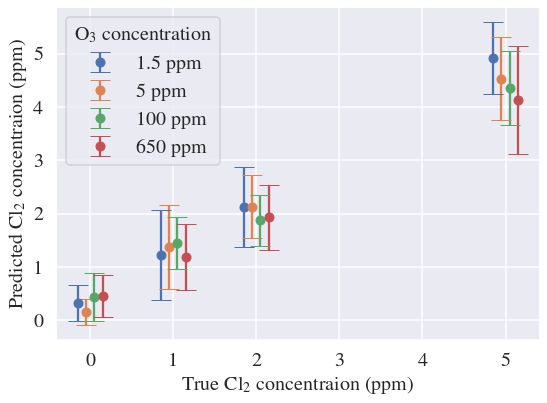

In [67]:
# 1 rgb 2 ozone 3 classification 4 concs 5 best_ytrue
labels = ["1.5 ppm", "5 ppm", "100 ppm", "650 ppm"]
xmove = [-0.15, -0.05, 0.05, 0.15]
plt.figure()
for i in range(4):
    y_true = np.concatenate(data[1][0][0][i][0])
    y_pred = np.concatenate(data[1][0][0][i][1])
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    y_unique = sorted(np.unique(y_true))
    result = np.zeros(shape=(4, 3))
    for j in range(len(y_unique)):
        y = y_unique[j]
        index = np.where(y_true == y)[0]
        mean = np.mean(y_pred[index])
        std = np.std(y_pred[index])
        result[j, 0] = y
        result[j, 1] = mean
        result[j, 2] = std
    plt.errorbar(x=result[:, 0]+xmove[i], y=result[:, 1], yerr=result[:, 2], capsize=10, fmt='o', label=labels[i])
plt.legend(title=r"O$_3$ concentration")
plt.xlabel(r"True Cl$_2$ concentraion (ppm)")
plt.ylabel(r"Predicted Cl$_2$ concentraion (ppm)")

([<matplotlib.axis.XTick at 0x2692723c048>,
 [Text(0, 0, '1.5'), Text(0, 0, '5'), Text(0, 0, '100'), Text(0, 0, '650')])

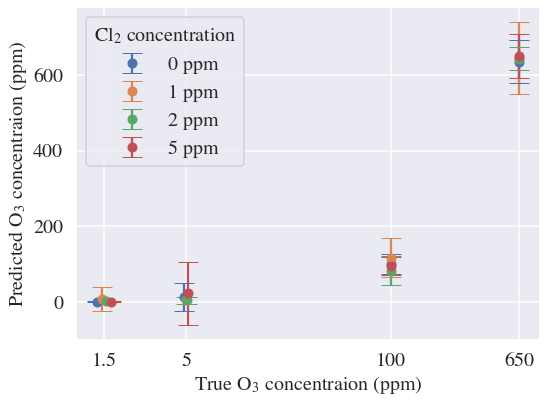

In [78]:
# 1 rgb 2 ozone 3 classification 4 concs 5 best_ytrue
labels = ["0 ppm", "1 ppm", "2 ppm", "5 ppm"]
xmove = [-0.15, -0.05, 0.05, 0.15]
xticks = [1.5, 5, 100, 650]
plt.figure()
for i in range(4):
    y_true = np.concatenate(data[1][1][0][i][0])
    y_pred = np.concatenate(data[1][1][0][i][1])
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    y_unique = sorted(np.unique(y_true))
    result = np.zeros(shape=(4, 3))
    for j in range(len(y_unique)):
        y = y_unique[j]
        index = np.where(y_true == y)[0]
        mean = np.mean(y_pred[index])
        std = np.std(y_pred[index])
        result[j, 0] = y
        result[j, 1] = mean
        result[j, 2] = std
    plt.errorbar(x=result[:, 0]+xmove[i], y=result[:, 1], yerr=result[:, 2], capsize=10, fmt='o', label=labels[i])
plt.legend(title=r"Cl$_2$ concentration")
plt.xlabel(r"True O$_3$ concentraion (ppm)")
plt.ylabel(r"Predicted O$_3$ concentraion (ppm)")
plt.xscale("log")
plt.xticks(xticks, xticks)

(0.0, 1.05)

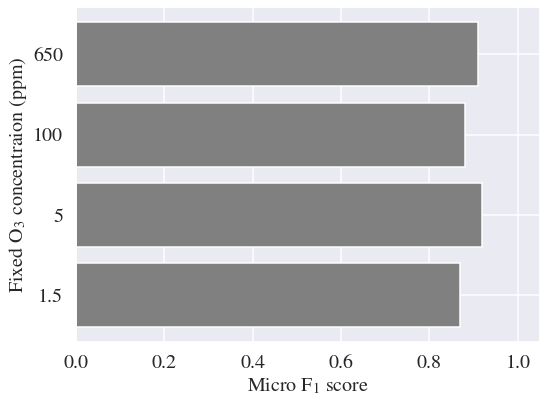

In [98]:
# 1 rgb 2 ozone 3 classification 4 concs 5 best_ytrue
labels = [1.5, 5, 100, 650]
plt.figure()
for i in range(4):
    y_true = np.concatenate(data[1][0][1][i][0])
    y_pred = np.concatenate(data[1][0][1][i][1])
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average="micro")
    plt.barh(i, f1, color="gray")
plt.yticks(range(4), labels)
plt.ylabel(r"Fixed O$_3$ concentraion (ppm)")
plt.xlabel(r"Micro F$_1$ score")
plt.xlim([0, 1.05])

(0.0, 1.05)

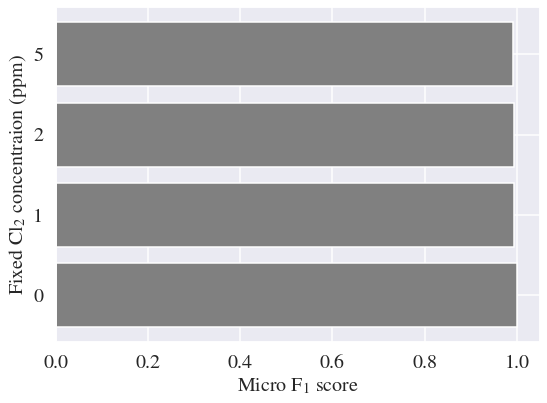

In [97]:
# 1 rgb 2 ozone 3 classification 4 concs 5 best_ytrue
labels = [0, 1, 2, 5]
plt.figure()
for i in range(4):
    y_true = np.concatenate(data[1][1][1][i][0])
    y_pred = np.concatenate(data[1][1][1][i][1])
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average="micro")
    plt.barh(i, f1, color="gray")
plt.yticks(range(4), labels)
plt.ylabel(r"Fixed Cl$_2$ concentraion (ppm)")
plt.xlabel(r"Micro F$_1$ score")
plt.xlim([0, 1.05])

In [53]:
matplotlib.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [108]:
data2ppm = pd.read_excel(DATA_DIR+"Normalized_light_intensity.xlsx", sheet_name=R"SI-1-2ppm Cl2 with different O3")

In [138]:
data650ppm = pd.read_excel(DATA_DIR+"Normalized_light_intensity.xlsx", sheet_name=R"SI-2-650ppm O3 mixtures")

In [141]:
data100ppm = pd.read_excel(DATA_DIR+"Normalized_light_intensity.xlsx", sheet_name=R"SI-3-100ppm O3 mixtures")

In [144]:
data5ppm = pd.read_excel(DATA_DIR+"Normalized_light_intensity.xlsx", sheet_name=R"SI-4-5ppm O3 mixtures")

In [146]:
data15ppm = pd.read_excel(DATA_DIR+"Normalized_light_intensity.xlsx", sheet_name=R"SI-5-1.5ppm O3 mixtures")

Text(0, 0.5, 'Normalized light intensity')

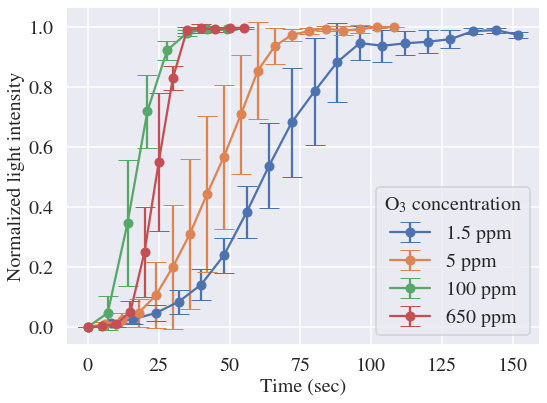

In [133]:
data2ppm650 = data2ppm.iloc[2:, :3].dropna().values.squeeze().astype(np.float32)
data2ppm100 = data2ppm.iloc[2:, 4:7].dropna().values.squeeze().astype(np.float32)
data2ppm5 = data2ppm.iloc[2:, 8:11].dropna().values.squeeze().astype(np.float32)
data2ppm15 = data2ppm.iloc[2:, 12:15].dropna().values.squeeze().astype(np.float32)
plt.figure()
plt.errorbar(x=data2ppm15[:, 0], y=data2ppm15[:, 1], yerr=data2ppm15[:, 2], capsize=10, fmt='o-', label="1.5 ppm")
plt.errorbar(x=data2ppm5[:, 0], y=data2ppm5[:, 1], yerr=data2ppm5[:, 2], capsize=10, fmt='o-', label="5 ppm")
plt.errorbar(x=data2ppm100[:, 0], y=data2ppm100[:, 1], yerr=data2ppm100[:, 2], capsize=10, fmt='o-', label="100 ppm")
plt.errorbar(x=data2ppm650[:, 0], y=data2ppm650[:, 1], yerr=data2ppm650[:, 2], capsize=10, fmt='o-', label="650 ppm")
plt.legend(title=r"O$_3$ concentration", loc="lower right")
plt.xlabel(r"Time (sec)")
plt.ylabel(r"Normalized light intensity")

Text(0, 0.5, 'Normalized light intensity')

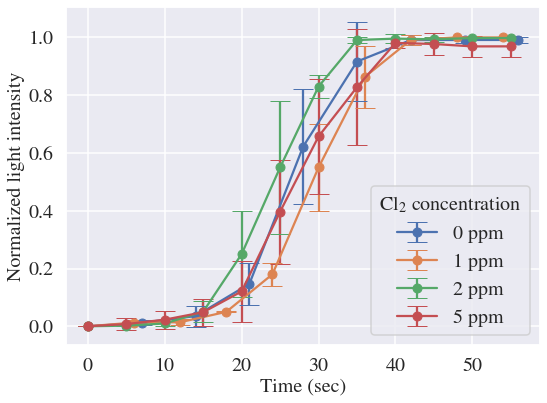

In [139]:
data650ppm0 = data650ppm.iloc[2:, :3].dropna().values.squeeze().astype(np.float32)
data650ppm1 = data650ppm.iloc[2:, 4:7].dropna().values.squeeze().astype(np.float32)
data650ppm2 = data650ppm.iloc[2:, 8:11].dropna().values.squeeze().astype(np.float32)
data650ppm5 = data650ppm.iloc[2:, 12:15].dropna().values.squeeze().astype(np.float32)
plt.figure()
plt.errorbar(x=data650ppm0[:, 0], y=data650ppm0[:, 1], yerr=data650ppm0[:, 2], capsize=10, fmt='o-', label="0 ppm")
plt.errorbar(x=data650ppm1[:, 0], y=data650ppm1[:, 1], yerr=data650ppm1[:, 2], capsize=10, fmt='o-', label="1 ppm")
plt.errorbar(x=data650ppm2[:, 0], y=data650ppm2[:, 1], yerr=data650ppm2[:, 2], capsize=10, fmt='o-', label="2 ppm")
plt.errorbar(x=data650ppm5[:, 0], y=data650ppm5[:, 1], yerr=data650ppm5[:, 2], capsize=10, fmt='o-', label="5 ppm")
plt.legend(title=r"Cl$_2$ concentration", loc="lower right")
plt.xlabel(r"Time (sec)")
plt.ylabel(r"Normalized light intensity")

Text(0, 0.5, 'Normalized light intensity')

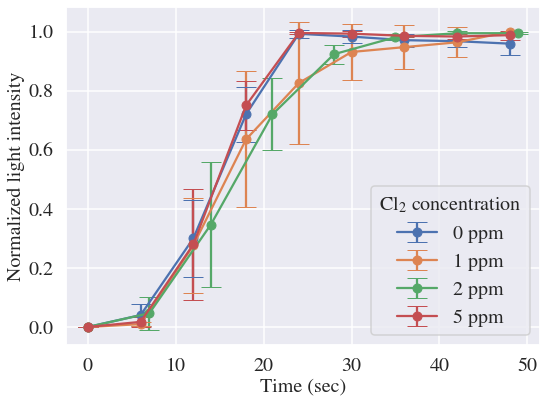

In [142]:
data100ppm0 = data100ppm.iloc[2:, :3].dropna().values.squeeze().astype(np.float32)
data100ppm1 = data100ppm.iloc[2:, 4:7].dropna().values.squeeze().astype(np.float32)
data100ppm2 = data100ppm.iloc[2:, 8:11].dropna().values.squeeze().astype(np.float32)
data100ppm5 = data100ppm.iloc[2:, 12:15].dropna().values.squeeze().astype(np.float32)
plt.figure()
plt.errorbar(x=data100ppm0[:, 0], y=data100ppm0[:, 1], yerr=data100ppm0[:, 2], capsize=10, fmt='o-', label="0 ppm")
plt.errorbar(x=data100ppm1[:, 0], y=data100ppm1[:, 1], yerr=data100ppm1[:, 2], capsize=10, fmt='o-', label="1 ppm")
plt.errorbar(x=data100ppm2[:, 0], y=data100ppm2[:, 1], yerr=data100ppm2[:, 2], capsize=10, fmt='o-', label="2 ppm")
plt.errorbar(x=data100ppm5[:, 0], y=data100ppm5[:, 1], yerr=data100ppm5[:, 2], capsize=10, fmt='o-', label="5 ppm")
plt.legend(title=r"Cl$_2$ concentration", loc="lower right")
plt.xlabel(r"Time (sec)")
plt.ylabel(r"Normalized light intensity")

Text(0, 0.5, 'Normalized light intensity')

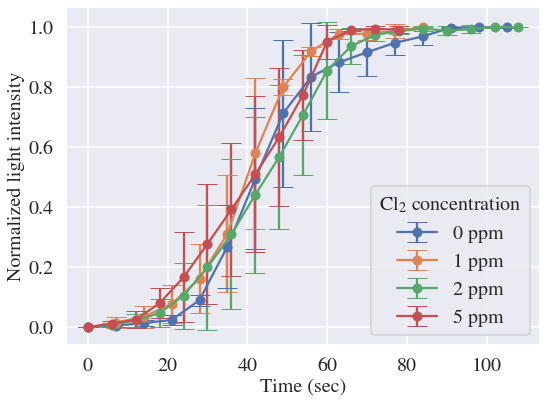

In [145]:
data5ppm0 = data5ppm.iloc[2:, :3].dropna().values.squeeze().astype(np.float32)
data5ppm1 = data5ppm.iloc[2:, 4:7].dropna().values.squeeze().astype(np.float32)
data5ppm2 = data5ppm.iloc[2:, 8:11].dropna().values.squeeze().astype(np.float32)
data5ppm5 = data5ppm.iloc[2:, 12:15].dropna().values.squeeze().astype(np.float32)
plt.figure()
plt.errorbar(x=data5ppm0[:, 0], y=data5ppm0[:, 1], yerr=data5ppm0[:, 2], capsize=10, fmt='o-', label="0 ppm")
plt.errorbar(x=data5ppm1[:, 0], y=data5ppm1[:, 1], yerr=data5ppm1[:, 2], capsize=10, fmt='o-', label="1 ppm")
plt.errorbar(x=data5ppm2[:, 0], y=data5ppm2[:, 1], yerr=data5ppm2[:, 2], capsize=10, fmt='o-', label="2 ppm")
plt.errorbar(x=data5ppm5[:, 0], y=data5ppm5[:, 1], yerr=data5ppm5[:, 2], capsize=10, fmt='o-', label="5 ppm")
plt.legend(title=r"Cl$_2$ concentration", loc="lower right")
plt.xlabel(r"Time (sec)")
plt.ylabel(r"Normalized light intensity")

Text(0, 0.5, 'Normalized light intensity')

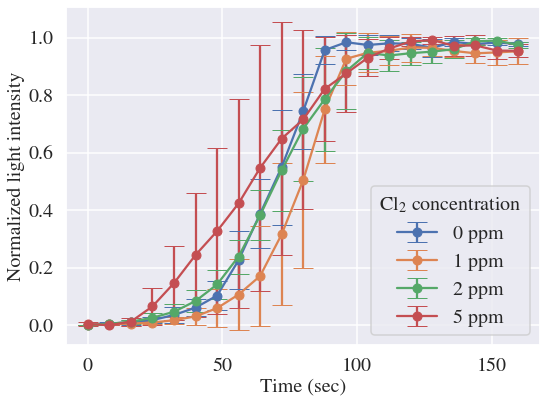

In [147]:
data15ppm0 = data15ppm.iloc[2:, :3].dropna().values.squeeze().astype(np.float32)
data15ppm1 = data15ppm.iloc[2:, 4:7].dropna().values.squeeze().astype(np.float32)
data15ppm2 = data15ppm.iloc[2:, 8:11].dropna().values.squeeze().astype(np.float32)
data15ppm5 = data15ppm.iloc[2:, 12:15].dropna().values.squeeze().astype(np.float32)
plt.figure()
plt.errorbar(x=data15ppm0[:, 0], y=data15ppm0[:, 1], yerr=data15ppm0[:, 2], capsize=10, fmt='o-', label="0 ppm")
plt.errorbar(x=data15ppm1[:, 0], y=data15ppm1[:, 1], yerr=data15ppm1[:, 2], capsize=10, fmt='o-', label="1 ppm")
plt.errorbar(x=data15ppm2[:, 0], y=data15ppm2[:, 1], yerr=data15ppm2[:, 2], capsize=10, fmt='o-', label="2 ppm")
plt.errorbar(x=data15ppm5[:, 0], y=data15ppm5[:, 1], yerr=data15ppm5[:, 2], capsize=10, fmt='o-', label="5 ppm")
plt.legend(title=r"Cl$_2$ concentration", loc="lower right")
plt.xlabel(r"Time (sec)")
plt.ylabel(r"Normalized light intensity")